## Universal Approximation Theorem - Gradient Descent Optimisation

Here we study the possibility to approximate functions with a MLP with a single hidden layer (n1 hidden units).
As activation functions, we use the sigmoid ('logit') function.

We generate training data - by assuming a function on the unit interval [0,1]. Here, we provide two families of functions:
* Beta distribution function: $b_{\alpha,\beta}(x)=x^\alpha\cdot(1-x)^\beta$
* Sine function: $sin_\omega(x)=\sin(2\pi\omega\cdot x)$

Finally, we use mini-batch-gradient descent to minimize MSE cost.

Goals:
* Learn how a given function can be represented with a single layer MLP;
* Understand that, in principle, it can be learned from sample data;
* Understand that the optimization based on plain gradient is not always straightforward; 
* Experience that the choice of the hyper-parameters number of hidden units, batchsize, learning rate is tricky. 


#### Plot Utility

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_function(x,y):
    plt.plot(x, y)
    plt.xlabel('x')
    plt.show()
    
def plot_compare_function(x,y1,y2, label1='', label2=''):
    plt.plot(x, y1, label=label1)
    plt.xlabel('x')
    plt.plot(x, y2, label=label2)
    if label1 and label2:
        plt.legend()
    plt.show()


### Model

In [74]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

In [128]:
def predict(X,W1,b1,W2,b2):
    """
    Computes the output for the single hidden layer network (n1 units) with 1d input and 1d output.
    
    Arguments:
    W1 -- weights of the hidden layer with shape (n1,1)
    b1 -- biases of the hidden units with shape (n1,1)
    W2 -- weights of the output layer with shape (1,n1)
    b2 -- bias of the output
    X  -- input data with m samples and shape (1,m)    Only ONE Dimension for Feature Points
    
    Returns:
    A2 -- Output from the network of shape (1,m) 
    
    Berechne die Prediction von einem Multi Layer Perceptron
    1 Layer: ypred = sigmoid(W*X + b)
    2 Layer: ypred = (W2*(W1* X + b1)+ b2)     (no sigmoid function!!!!)
    
    DImensionen Bsp:  [1,3]*([3,1]*[1,5] + [3,1]) + 1
                      [1,3]*[3,5] + 1
                      [1,5] = One Dimensional Result for 5 inputs
    """
    
    ### START YOUR CODE ###
    m = X.shape[1]
    n = W1.shape[0]

    A1 = sigmoid(np.dot(W1,X) + b1)
    A2 = np.dot(W2, A1) + b2
    
    '''
    h1 = np.dot(W1,X.T) + b1
    z1 = sigmoid(h1)
    h2 = np.dot(W2,z1) + b2
    # z2 = sigmoid(h2)   NO SIGMOID FUNCTION on last level 
    A2 = h2
    #A2 = np.exp(h2)/(np.sum(np.exp(h2)))    no idea why no softmax
    '''
   
    ### END YOUR CODE ###
    
    return A2

#### TEST - Prediction

In [129]:
W1 = np.array([0.4,0.2,-0.4]).reshape(3,1) # n1 = 3
b1 = np.array([0.1,0.1,0.1]).reshape(3,1)
W2 = np.array([1,2,1]).reshape(1,3)
b2 = -1
X = np.linspace(-1,1,5).reshape((1,5))
Ypred = predict(X,W1,b1,W2,b2)
print(Ypred)
Yexp = np.array([0.99805844, 1.04946333, 1.09991675, 1.14913132, 1.19690185]).reshape(1,5)
np.testing.assert_array_almost_equal(Ypred,Yexp,decimal=8)

[[0.99805844 1.04946333 1.09991675 1.14913132 1.19690185]]


#### Cost

In [77]:
def cost(Y,Ypred):
    """
    Computes the MSE cost for given ground truth Y and predicted Ypred
    Uses the predict function defined above.
    
    Arguments:
    Y -- ground truth output with shape (1,m) 
    Ypred -- predicted output with shape (1,m) 
    
    Returns:
    cost -- the MSE cost divided by 2.
    """
    ### START YOUR CODE ###
    
    cost = 1/(np.size(Ypred)*2) * np.sum((Y - Ypred)**2)

    
    
    
    ### END YOUR CODE ###
    return cost

In [78]:
def invSigmoid(z):
    return(sigmoid(z) * (1 - sigmoid(z)))

#### TEST - Cost

In [79]:
W1 = np.array([4,5,6]).reshape(3,1)
W2 = np.array([1,2,3]).reshape(1,3)
b1 = np.array([1,1,1]).reshape(3,1)
b2 = 2
X = np.linspace(-1,1,5).reshape(1,5)
Ypred = predict(X,W1,b1,W2,b2)
print(Ypred)
Y = 2.0*np.ones(5).reshape(1,5)
c = cost(Y,Ypred)
print(c)
cexp = 9.01669099
np.testing.assert_almost_equal(c,cexp,decimal=8)

[[2.10347685 2.99140124 6.38635147 7.83999104 7.98562875]]
9.016690991741989


#### Gradient

In [144]:
def gradient(W1,b1,W2,b2,X,Y):
    """
    Computes the gradient of the MSE cost for a single hidden layer network with 1d input and 1d output.
    The parts of the gradient associated with the weights array and bias array for the hidden layer, 
    the weights array and the bias for the output layer are provided as separate numpy arrays of according 
    dimension. 
    
    Arguments:    
    W1 -- weights of hidden layer with shape (n1,1)
    b1  -- biases of hidden layer with shape (n1,1)
    W2 -- weights of output layer with shape (1,n1)
    b2  -- biases of output layer
    X  -- input data with shape (1,m)
    Y  -- labels with shape (1,m)
    
    m = nr of samples
    n1 = nr of hidden layer Points
    
    ACHTUNG: NUR 1 dimensionaler Input X und Ooutput ypred
    
    To calculate the gradient we calculate the derivatives of all the Signals no their parapeters
    And then with the chain rule we can multiply there derivatives
    
    aE/aW1 = aE/ah2  * ah2/ah2in  ah2in/aW1 * 
    
    Returns:
    gradient -- dictionary with the gradients w.r.t. W1, W2, b1, b2 and according keys 
                'dW1' with shape (n1,1)
                'db1' with shape (n1,1)
                'dW2' with shape (1,n1)
                'db2' a scalar
                
             
    """
    ### START YOUR CODE ###

    m = X.shape[0]
    n1 = W1.shape[0]
    
    
    
    
    #V1
    #dw with mse is: 1/m * sum(ypred * (1 - ypred) *( ypred - y)* X)   (generally)
    #for neurons: yred = A1, but the "cost comparison" still has to be done by ypred
    #dW1 = (1/m*np.sum(diff*A1.T*(1-A1)*X, axis=1)*W2).T 
    #dW2 = (1/m*np.sum(diff*A1, axis=1)).reshape(1,n1)
    #db1 = (1/m*np.sum(diff*A1*(1-A1), axis=1)*W2).T
    #db2 = 1/m*np.sum(diff)
    '''
    V2
    dW1 = (1/m*np.sum(diff*A1*(1-A1)*X, axis=1)*W2).T
    dW2 = (1/m*np.sum(diff*A1, axis=1)).reshape(1,-1)
    db1 = (1/m*np.sum(diff*A1*(1-A1), axis=1)*W2).T
    db2 = 1/m*np.sum(diff)
    '''
    
    '''
    v3
    dW1 = 1/(m) * np.sum(np.dot(np.dot(np.dot(np.dot(diff , A1.T),(1 - A1)), X),  W2).T)
    dW2 = 1/(m) * np.sum(np.dot(diff,A1.T))    
    db1 = 1/(m) * np.sum( np.dot(np.dot(np.dot(diff,A1.T),(1 - A1)).T,W2))
    db2 = 1/m*np.sum(diff)
    '''
    
    
    #V4
    if(m == 1):
        print(X)
    
    
    X = X.reshape(1,m)
    print("X : ",X.shape)
    z = np.dot(W1, X) + b1              # calculate input of 1st neuron
    AL1 = sigmoid(z)                      #calculate Activation of 1st neuron
    
    AL2 = predict(X, W1, b1, W2, b2)      #calculate Activation of last (2nd) neuron
    yPred = AL2
 
    print("Ypred : ", yPred.shape)
    print(" Y : ", Y.shape)
    diff = yPred - Y.T                      #calc error (for siplicity reasons)
    
    #apply chain rule derivatives for all dWs and dBs
    
    #dW2 change of cost(error) under change of W2 (on Level L2)
    dW2 = 2 * np.dot(diff, invSigmoid(AL1).T)        #sigmoid(AL1) * (1 - sigmoid(AL1)) = derivative of Sigmoid relative to AL1
    db2 = 2 *np.dot(diff, invSigmoid(1).T)           #input of sigmoid = 1 (because derivative of AzL to Abl = 1)
    
    #on 1st Level (L1) of neurons (propagate further back)
    print(diff.shape)
    print(np.dot(invSigmoid(W2).T,diff).shape)
    dW1 = 2 * np.dot(np.dot(invSigmoid(W2).T,diff ), invSigmoid(X).T)
    db1 = 2 * np.dot(np.dot(invSigmoid(W2).T,diff ), invSigmoid(1).T)
    
    
    
   
    ### END YOUR CODE ###
    return {'dW1':dW1, 'dW2':dW2, 'db1':db1, 'db2':db2}

#### TEST - Gradient

In [134]:
#n1 = 3  (3 neurons)
#m = 7   (7 samples)

W1 = np.array([4,5,6]).reshape(3,1)
W2 = np.array([1,2,3]).reshape(1,3)
b1 = np.array([1,1,1]).reshape(3,1)
b2 = 2
X = np.array([1,2,3,4,5,6,7]).reshape((7,1))
Y = np.array([2,2,2,2,2,2,2]).reshape((1,7))
gradJ = gradient(W1,b1,W2,b2,X,Y)

dW1exp = np.array([0.00590214,0.00427602,0.00234663]).reshape(W1.shape)
db1exp = np.array([0.00579241,0.004247,0.00234079]).reshape(b1.shape)
dW2exp = np.array([5.99209251,5.99579451,5.99714226]).reshape(W2.shape)
db2exp = 5.99792323
print(gradJ['dW1'])
#print(gradJ['db1'])
    
#print(gradJ['dW2'])
#print(gradJ['db2'])
np.testing.assert_array_almost_equal(gradJ['dW1'],dW1exp,decimal=8)
np.testing.assert_array_almost_equal(gradJ['db1'],db1exp,decimal=8)
np.testing.assert_array_almost_equal(gradJ['dW2'],dW2exp,decimal=8)
np.testing.assert_almost_equal(gradJ['db2'],db2exp,decimal=8)

X :  (7, 1)


ValueError: shapes (3,1) and (3,7) not aligned: 1 (dim 1) != 3 (dim 0)

#### Training Loop

In [150]:
def train(X,Y,n1,nepochs,batchsize=32,learning_rate=0.1):
    """
    Performs the training by using MBGD for a MLP with a single hidden layer (n1 units) and 1d input and output layer.
    Input:
    n1 = nr of neurons in hidden layer
    
    
    It starts with initializing the parameters:
    * the weights and the biases for the hidden units : W1,b1 of shape (n1,1) 
    * the weights and the bias for the output layer: W2 of shape (1,n1) and scalar b2 

    Then, it loops over the epochs and per epoch over the mini-batches. The number of batches is determined from the 
    batchsize.
    """
    # initialize weights and bias in Dimensions for n1 neurons in hidden layer
    W1 = np.random.uniform(-1,1,n1).reshape(n1,1)*0.05
    b1 = np.zeros((n1,1),dtype='float')
    W2 = np.random.uniform(-1,1,n1).reshape(1,n1)*0.05
    b2 = 0.0
    
        
    #m = X.shape[1]
    m = np.size(X)
    mb = int(m/batchsize)      #nr of mini batches
    indices = np.arange(m)     #indices of one mini Batch (from 1st to last item)
    np.random.shuffle(indices) # shuffle indices 
    # remember the epoch id and cost after each epoch for constructing the learning curve at the end
    costs = [] 
    epochs = []

    # Initial cost value:
    epochs.append(0)
    Ypred = predict(X.T,W1,b1,W2,b2)
   
    costs.append(cost(Y,Ypred)) 
    
    # training loop
    for epoch in range(nepochs):
        
        ### START YOUR CODE ###
        #shuffle 
        np.random.shuffle(indices)
        deltaW = []
        #iterate with MiniBatch
        
        for iteration in range(mb):
            print(iteration)
            #splitting of Set into mini batches
            #xMini = X[:,iteration*batchsize:(iteration+1)*batchsize]
            #yMini = Y[:,iteration*batchsize:(iteration+1)*batchsize]
            
            #miniBatches witch miniBatch Class
            batches = MiniBatches(X, Y, batchsize)
            
            #calculate gradient
            gradJ = gradient(W1, b1, W2, b2, batches.getX(), batches.getY())
            #adjust params
            W1 = W1 - learning_rate*gradJ['dW1']
            b1 = b1 - learning_rate*gradJ['db1']
            W2 = W2 - learning_rate*gradJ['dW2']
            b2 = b2 - learning_rate*gradJ['db2']
            deltaW.append(gradJ['dW1'])
            batches = batches.next()
        #print('epoch: {}, cost: {}'.format(epochs[-1], costs[-1]))
        #print(deltaW)
        ### END YOUR CODE ###
        epochs.append(epoch+1)
        Ypred = predict(X,W1,b1,W2,b2)
        costs.append(cost(Y,Ypred))         
    
    #print(costs[-1])    
    params = {'W1':W1, 'W2':W2,'b1':b1,'b2':b2}    
    return params, np.array(epochs), np.array(costs)

In [151]:
class MiniBatches():
    
    def __init__(self, x, y, batchsize):
        self.x = x
        self.y = y
        m = x.shape[1]
        if not batchsize:
            self.batchsize = m
        else:
            self.batchsize = batchsize
        self.n = x.shape[0]
        self.mb = int(m/batchsize)
        self.indices = np.arange(m)
        np.random.shuffle(self.indices)
        self.ib = 0
        
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def number_of_batches(self):
        return self.mb
        
    def next(self):
        it = self.indices[self.ib*batchsize:(self.ib+1)*batchsize]
        xbatch = self.x[:,it].reshape(self.n,batchsize)
        ybatch = self.y[:,it].reshape(1,batchsize)
        self.ib += 1
        return xbatch, ybatch

### Generate the Training Data 

In [83]:
def beta_fct(x,alpha,beta):
    """
    Parameters:
    x - input array
    alpha, beta -- larger values lead to more pronounced peaks
    """
    c = alpha/(alpha+beta)
    norm = c**alpha*(1-c)**beta
    return x**alpha*(1-x)**beta/norm

In [84]:
def sin_fct(x,omega):
    """
    Parameters:
    x -- input array
    omega -- frequency that defines the integer number of cycles within the unit interval
    """
    return np.sin(x*2*np.pi*omega)

In [85]:
def generate_inputs(m, func, random=True, vargs=None):
    """
    Generates m (x,y=f(x))-samples by either generating random x-values in the unit interval (random=True) or by 
    generating a grid of such values. Then the y values (used as labels below) are created from the function object 
    `func`.
    Parameter needed to define the function `func` can be passed as vargs-dict. 
    """
    if random:
        x = np.random.rand(1,m)
        y = func(x, **vargs)
    else:
        x = np.linspace(0,1,m).reshape(1,m)
        y = func(x,**vargs)
    return x,y

In [86]:
m = 1000
func = beta_fct
vargs={'alpha':2.0,'beta':2.0}
#func = sin_fct
#vargs={'omega':3.0}

X,Y = generate_inputs(m,func,vargs=vargs)

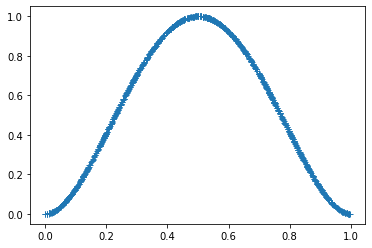

In [87]:
plt.plot(X[0,:],Y[0,:],'+')

### Normalize the Input and Output

It turns out that it is important to normalize the input and the output data here.
Remember the mean and stdev computed for the training data so that you can also apply it to the test data!

In [88]:
def normalize(X, mu=None, stdev=None):
    """
    Normalizes the data by using z-normalization. If mu and stdev are NOT specified, mean and stedev are 
    computed from the given samples.   
    
    Returns:
    X1 -- normalized data (array of the same shape as input)
    mu -- mean
    stdev -- standard deviation
    """
    ### START YOUR CODE ###
    
    mu = np.mean(X)
    
    stdev = np.std(X)
   
    X1 = (X - mu)/stdev
    
    
    
    ### END YOUR CODE ###
    
    return X1,mu,stdev

In [89]:
def inv_normalize(X1, mu, stdev):
    """
    Invert the normalization. This is needed to bring the predicted values back to the original scale.

    Returns:
    X -- unnormalized data (array of the same shape as input X1)
    """
    ### START YOUR CODE ###

    X = (X1 * stdev) + mu
    
       
    
    ### END YOUR CODE ###
    
    return X

In [90]:
# Test Norm (selfmade)
X = np.arange(1,5)
print(X)
X,mu,stdev = normalize(X)
print(X)
print(mu)
print(stdev)
mu_true = 2.5
stev_true = 1.118034

X = inv_normalize(X,mu,stdev)
print(X)

[1 2 3 4]
[-1.34164079 -0.4472136   0.4472136   1.34164079]
2.5
1.118033988749895
[1. 2. 3. 4.]


In [91]:
# Test Input Normalization
x, _, _ = normalize(X)
y, _, _ = normalize(Y)
#plt.plot(x[0,:],y[0,:],'+')
print(x.shape)
print(y.shape)

(4,)
(1, 1000)


### Perform the Training

Includes generating and normalizing the data and training. Test data can be generated as non-random.<br>
Make sure that you do the test performance on the right scales (of both x-values and y-values)!

In [152]:
from sklearn.model_selection import train_test_split

# settings
mtrain = 1000
mtest = 1000
func = beta_fct                  #Y   (soll fuktion)
#print(func)
vargs={'alpha':2.0,'beta':2.0}

n_hidden = 10 # number of hidden units
nepochs = 100 # number of epochs
batchsize = 32
learning_rate = 0.1

### START YOUR CODE ###

# generate data (train and test)
m = mtrain + mtest
testfactor = mtest/m
X,Y = generate_inputs(m,func,random=False,vargs=vargs)

x_train, x_test, y_train, y_test = train_test_split(X.T, Y.T, test_size=testfactor, random_state=1)

# normalize Data
normalizeData = True
if normalizeData:
    x_train, muX_train, stdevX_train = normalize(x_train)
    y_train, muY_train, stdevY_train = normalize(y_train)
 
    
# train 
                 
params, epochs, costs =train(x_train,y_train,n_hidden,nepochs,batchsize=batchsize,learning_rate=learning_rate)
if normalizeData:
    x_train = inv_normalize( x_train, muX_train, stdevX_train)
    y_train = inv_normalize(y_train, muY_train, stdevY_train)
    
    

### END YOUR CODE ###

plt.semilogy(epochs,costs)


0
X :  (1, 1000)
Ypred :  (1, 1000)
 Y :  (1000, 1)
(1, 1000)
(10, 1000)


ValueError: cannot reshape array of size 1000 into shape (1000,32)

### Test

Compute the predicted values on the test set and compute the MSE cost.
Prepare a (x,y)-plot with the ground truth test values and the predicted values. 

In [132]:
### START YOUR CODE ###
#Wurde schon in Train gemacht mit testsplit
'''
mtest = 1000
Xtest,Ytest = generate_inputs(mtest, func, random=False, vargs=vargs)
'''

if normalizeData:
    x_test, muX_test, stdevX_test = normalize(x_test)
    y_test, muY_test, stdevY_test = normalize(y_test)
         
W1 = params['W1']
b1 = params['b1']
W2 = params['W2']
b2 = params['b2']
ypred_test = predict(x_test,W1,b1,W2,b2)

if normalizeData:
    #x_test = inv_normalize(x_test, muX_test, stdevX_test)
    y_test = inv_normalize(y_test, muY_test, stdevY_test)
    ypred_test = inv_normalize(ypred_test, muY_test, stdevY_test)


### END YOUR CODE ###
print(x_test.shape)
print(ypred_test.shape)
#plt.plot(x_test[0,:],y_test[0,:],'b-')
#plt.plot(x_test[0,:],Ypred_test[0,:],'r-')

(1000, 1)
(1, 1000)
